# 复杂数据局部性建模
树回归
- 优点：可以对复杂和非线性的数据建模
- 缺点：结果不易理解
- 使用数据类型：数值型和标称型

CART是十分著名且广泛记在的树构建算法，使用二元切分处理连续性变量，对CART稍作修改就可以处理回归问题

# 连续和离散特征的树的构建
使用字典来存储树结构，字典包含：
- 带切分的特征
- 待切分的特征值
- 右子树
- 左子树

In [1]:
class treeNode():
    def __init__(self,feat,val,right,left):
        featureToSplitOn = feat
        valueOfSplit = val
        rightBranch = right
        leftBranch = left
        

In [2]:
import numpy as np

def loadDataSet(fileName):
    dataMat = []
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        fltLine = list(map(float,curLine))
        dataMat.append(fltLine)
    return dataMat

def binSplitDataSet(dataSet,feature,value):
    mat0 = dataSet[np.nonzero(dataSet[:,feature] > value)[0],:]
    mat1 = dataSet[np.nonzero(dataSet[:,feature] <= value)[0],:]
    return mat0,mat1

In [3]:
testMat = np.mat(np.eye(4))
testMat

matrix([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

In [4]:
mat0,mat1 = binSplitDataSet(testMat,1,0.5)
mat0

matrix([[0., 1., 0., 0.]])

In [5]:
mat1

matrix([[1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]])

# CART算法用于回归


In [6]:
# 实现chooseBestSplit()函数，用最优方式划分数据集并生成相应的叶节点
# 注意，此处默认当前数据最后一列为标签

# 负责产生叶节点
def regLeaf(dataSet):
    # print(dataSet.shape)
    return np.mean(dataSet[:,-1])

# 误差估计函数，在该函数给定数据上计算目标变量的平方误差和
def regErr(dataSet):
    return np.var(dataSet[:,-1])*np.shape(dataSet)[0]


def chooseBestSplit(dataSet,leafType=regLeaf, errType=regErr,ops=(1,4)):
    tolS = ops[0]
    tolN = ops[1]
    # 所有标签值相等，则直接返回
    if len( set(dataSet[:,-1].T.tolist()[0]) ) == 1:
        # print(dataSet.shape)
        return None, leafType(dataSet)
    m,n = np.shape(dataSet)
    S = errType(dataSet)
    bestS = np.inf
    bestIndex = 0
    bestValue = 0
    for featIndex in range(n-1):
        for splitVal in set(dataSet[:,featIndex].T.A.tolist()[0]):
            mat0,mat1 = binSplitDataSet(dataSet,featIndex,splitVal)
            if (np.shape(mat0)[0] < tolN) or (np.shape(mat1)[0] < tolN):
                continue
            newS = errType(mat0) + errType(mat1)
            if newS<bestS:
                bestIndex = featIndex
                bestValue = splitVal
                bestS = newS
    # 测试方差优化程度，过小则放弃更新
    if (S-bestS)<tolS:
        return None,leafType(dataSet)
    mat0,mat1 = binSplitDataSet(dataSet,bestIndex,bestValue)
    if (np.shape(mat0)[0] < tolN) or (np.shape(mat1)[0] < tolN):
        return None,leafType(dataSet)
    return bestIndex,bestValue

def createTree(dataSet ,leafType=regLeaf, errType=regErr, ops=(1,4)):
    feat,val = chooseBestSplit(dataSet,leafType,errType,ops)
    if feat == None:
        return val
    retTree = {}
    retTree['spInd'] = feat
    retTree['spVal'] = val
    lSet,rSet = binSplitDataSet(dataSet,feat,val)
    retTree['left'] = createTree(lSet,leafType,errType,ops)
    retTree['right'] = createTree(rSet,leafType,errType,ops)
    return retTree

In [7]:
import matplotlib.pyplot as plt

def showData(dataMat):
    fig = plt.figure()
    ax = fig.add_subplot(111)       
    ax.scatter(dataMat[:,0].T.A[0],dataMat[:,1].T.A[0])
    plt.show()

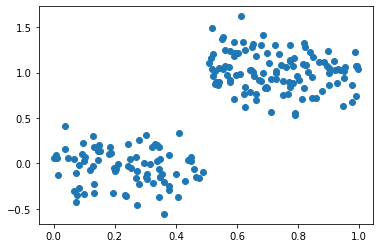

{'spInd': 0,
 'spVal': 0.48813,
 'left': 1.0180967672413792,
 'right': -0.04465028571428572}

In [8]:
myDat = loadDataSet('../data/RegressionTree/ex00.txt')
myMat = np.mat(myDat)
showData(myMat)
createTree(myMat)

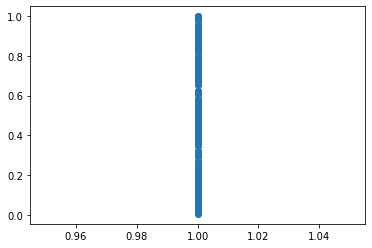

{'spInd': 1,
 'spVal': 0.39435,
 'left': {'spInd': 1,
  'spVal': 0.582002,
  'left': {'spInd': 1,
   'spVal': 0.797583,
   'left': 3.9871632,
   'right': 2.9836209534883724},
  'right': 1.980035071428571},
 'right': {'spInd': 1,
  'spVal': 0.197834,
  'left': 1.0289583666666666,
  'right': -0.023838155555555553}}

In [9]:
myDat1 = loadDataSet('../data/RegressionTree/ex0.txt')
myMat1 = np.mat(myDat1)
showData(myMat1)
createTree(myMat1)

# 树剪枝(Tree pruning)
- 树的节点过多，则模型可能发生了过拟合，可以考虑在测试集上使用交叉验证技术发现过拟合
- 通过降低决策树的复杂度来避免过拟合的过程叫做Pruning
- chooseBestSplit()中的提前终止条件，实际上是一种预剪枝(prePruning)
- 另一种需要用到测试集和训练集的称为后剪枝(postPruning)


## 预剪枝
上述实验结果大致令人满意，但是显然树的构建算法对输入tolS和tolN非常敏感，如果使用其他值可能不容易获得如此效果，例如
```python
createTree(myMat,ops=(0,1))
```
将会构建臃肿的树，其中每个样本都分配了一个叶节点

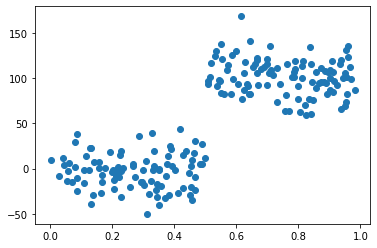

{'spInd': 0, 'spVal': 0.499171, 'left': {'spInd': 0, 'spVal': 0.729397, 'left': {'spInd': 0, 'spVal': 0.952833, 'left': {'spInd': 0, 'spVal': 0.958512, 'left': 105.24862350000001, 'right': 112.42895575000001}, 'right': {'spInd': 0, 'spVal': 0.759504, 'left': {'spInd': 0, 'spVal': 0.790312, 'left': {'spInd': 0, 'spVal': 0.833026, 'left': {'spInd': 0, 'spVal': 0.944221, 'left': 87.3103875, 'right': {'spInd': 0, 'spVal': 0.85497, 'left': {'spInd': 0, 'spVal': 0.910975, 'left': 96.452867, 'right': {'spInd': 0, 'spVal': 0.892999, 'left': 104.825409, 'right': {'spInd': 0, 'spVal': 0.872883, 'left': 95.181793, 'right': 102.25234449999999}}}, 'right': 95.27584316666666}}, 'right': {'spInd': 0, 'spVal': 0.811602, 'left': 81.110152, 'right': 88.78449880000001}}, 'right': 102.35780185714285}, 'right': 78.08564325}}, 'right': {'spInd': 0, 'spVal': 0.640515, 'left': {'spInd': 0, 'spVal': 0.666452, 'left': {'spInd': 0, 'spVal': 0.706961, 'left': 114.554706, 'right': {'spInd': 0, 'spVal': 0.698472, '

In [10]:
myDat2 = loadDataSet('../data/RegressionTree/ex2.txt')
myMat2 = np.mat(myDat2)
showData(myMat2)
print(createTree(myMat2))

实际上该数据集仅仅是在y轴上扩大了100倍，由此可见停止条件tolS对误差的数量级十分敏感，如果在选项中花费时间应对上述误差容忍取平方，或许能得到仅两个点组成的树

In [11]:
createTree(myMat2,ops=(10000,4))

{'spInd': 0,
 'spVal': 0.499171,
 'left': 101.35815937735848,
 'right': -2.637719329787234}

## 后剪枝
首先构建足够大、足够复杂的树便于剪枝，接下来从上而下寻找叶节点，用测试机判断能否降低测试误差，可以的话就进行合并

In [12]:
def isTree(obj):
    return (type(obj).__name__=='dict')

def getMean(tree):
    if isTree(tree['right']):
        tree['right'] = getMean(tree['right'])
    if isTree(tree['left']):
        tree['left'] = getMean(tree['left'])
        
    return (tree['left']+tree['right'])/2.0

def prune(tree,testData):
    
    if np.shape(testData)[0] ==0:
        return getMean(tree)
    
    if (isTree(tree['left']) or isTree(tree['right'])):
        lSet,rSet = binSplitDataSet(testData,tree['spInd'],tree['spVal'])
        
    if (isTree(tree['left'])):
        tree['left'] = prune(tree['left'],lSet)
    if (isTree(tree['right'])):
        tree['right'] = prune(tree['right'],rSet)
        
    if not isTree(tree['left']) and not isTree(tree['right']):
        lSet,rSet = binSplitDataSet(testData,tree['spInd'],tree['spVal'])
        errorNoMerge = np.sum(np.power(lSet[:,-1]-tree['left'],2))+\
            np.sum(np.power(rSet[:,-1]-tree['right'],2))
        treeMean = (tree['left']+tree['right'])/2.0
        errorMerge = np.sum(np.power(rSet[:,-1]-treeMean,2))
        if errorMerge < errorNoMerge:
            # print('Merging')
            return treeMean
        else:
            return tree
    else:
        return tree

In [13]:
myTree = createTree(myMat2,ops=(0,1))
myDatTest = loadDataSet('../data/RegressionTree/ex2test.txt')
myMat2Test = np.mat(myDatTest)
print(prune(myTree,myMat2Test))

{'spInd': 0, 'spVal': 0.499171, 'left': {'spInd': 0, 'spVal': 0.729397, 'left': {'spInd': 0, 'spVal': 0.952833, 'left': 105.7886099375, 'right': {'spInd': 0, 'spVal': 0.759504, 'left': {'spInd': 0, 'spVal': 0.763328, 'left': {'spInd': 0, 'spVal': 0.769043, 'left': {'spInd': 0, 'spVal': 0.790312, 'left': {'spInd': 0, 'spVal': 0.806158, 'left': {'spInd': 0, 'spVal': 0.815215, 'left': {'spInd': 0, 'spVal': 0.833026, 'left': {'spInd': 0, 'spVal': 0.841547, 'left': {'spInd': 0, 'spVal': 0.841625, 'left': {'spInd': 0, 'spVal': 0.944221, 'left': 82.86875062499999, 'right': {'spInd': 0, 'spVal': 0.85497, 'left': {'spInd': 0, 'spVal': 0.936524, 'left': 110.03503850000001, 'right': {'spInd': 0, 'spVal': 0.934853, 'left': 65.548418, 'right': {'spInd': 0, 'spVal': 0.925782, 'left': 115.753994, 'right': {'spInd': 0, 'spVal': 0.910975, 'left': 89.70073275, 'right': {'spInd': 0, 'spVal': 0.901444, 'left': 112.664071, 'right': {'spInd': 0, 'spVal': 0.901421, 'left': 87.300625, 'right': {'spInd': 0, 's

虽然已经剪掉了大量节点，但并没到达预期的剪枝成两部分，这说明**后剪枝不如预剪枝有效，一般的为了寻求最佳模型，可以同时使用两种剪枝技术**

# 模型树
用树来对数据建模，除了把叶节点简单设定为常数值之外，另一种方法是将叶节点设为分段线性函数（piecewise linear）指模型由多个先行片段组成。

利用树生成算法将数据切分，每份数据都可以很容易的用线性模型表示。

In [14]:
def linearSlove(dataSet):
    # 处理数据
    m,n = np.shape(dataSet)
    X = np.mat(np.ones((m,n)))
    Y = np.mat(np.ones((m,1)))
    X[:,1:n] = dataSet[:,0:n-1]
    Y = dataSet[:,-1]
    
    xTx = X.T*X
    if np.linalg.det(xTx) == 0.0:
        print('this matrix is singular!')
    
    ws = xTx.I *(X.T*Y)
    return ws,X,Y

def modelLeaf(dataSet):
    ws,X,Y = linearSlove(dataSet)
    return ws

def modelErr(dataSet):
    ws,X,Y = linearSlove(dataSet)
    yHat = X*ws
    return np.sum(np.power(Y-yHat,2))

In [15]:
myMat2 = np.mat(loadDataSet('../data/RegressionTree/exp2.txt'))

In [16]:
createTree(myMat2,modelLeaf,modelErr)

{'spInd': 0,
 'spVal': 0.285477,
 'left': matrix([[1.69855694e-03],
         [1.19647739e+01]]),
 'right': matrix([[3.46877936],
         [1.18521743]])}

# 树回归和标准回归比较

In [17]:
def regTreeEval(model,inDat):
    return float(model)

def modelTreeEval(model,inDat):
    n = np.shape(inDat)[1]
    X = np.mat(np.ones((1,n+1)))
    X[:,1:n+1] = inDat
    return float(X*model)

def treeForeCast(tree,inData,modelEval = regTreeEval):
    if not isTree(tree):
        return modelEval(tree,inData)
    if inData[tree['spInd']] > tree['spVal']:
        if isTree(tree['left']):
            return treeForeCast(tree['left'],inData,modelEval)
        else:
            return modelEval(tree['left'],inData)
    else:
        if isTree(tree['right']):
            return treeForeCast(tree['right'],inData,modelEval)
        else:
            return modelEval(tree['right'],inData)
def createForeCast(tree,testData,modelEval = regTreeEval):
    m = len(testData)
    yHat = np.mat(np.zeros((m,1)))
    for i in range(m):
        yHat[i,0] = treeForeCast(tree,np.mat(testData[i]),modelEval)
    return yHat

In [18]:
# 创建回归树并测试效果
trainMat = np.mat(loadDataSet('../data/RegressionTree/bikeSpeedVsIq_train.txt'))
testMat = np.mat(loadDataSet('../data/RegressionTree/bikeSpeedVsIq_test.txt'))
myTree = createTree(trainMat,ops=(1,20))
yHat = createForeCast(myTree,testMat[:,0],regTreeEval)
np.corrcoef(yHat,testMat[:,1],rowvar=0)[0,1]

0.9640852318222141

In [19]:
# 创建并测试模型树
myTree = createTree(trainMat,modelLeaf,modelErr,(1,20))
yHat = createForeCast(myTree,testMat[:,0],modelTreeEval)
np.corrcoef(yHat,testMat[:,1],rowvar=0)[0,1]

0.9760412191380593

$R^2$越接近1.0越好,从上面可以看出模型树的结果比回归树好。下面是标准线性回归的结果

In [20]:
# 创建并测试线性模型
ws,X,Y = linearSlove(trainMat)
ws

matrix([[37.58916794],
        [ 6.18978355]])

In [21]:
for i in range(np.shape(testMat)[0]):
    yHat[i] = testMat[i,0]*ws[1,0]+ws[0,0]
np.corrcoef(yHat,testMat[:,1],rowvar=0)[0,1]

0.9434684235674763